# TP Coding an autoencoder in tensorflow/keras

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore autoencoders and variational autoencoders applied to a simple dataset. In this first part, we will look at an autoencoder applied to MNIST.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import pdb
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


First, we define a function to load the mnist dataset.

In [2]:
def load_data():
  (X_train, Y_train_scalar), (X_test, Y_test_scalar) = mnist.load_data()

  n_max = 10000
  X_train = X_train[0:n_max,:,:]
  X_test = X_test[0:n_max,:,:]
  Y_train_scalar = Y_train_scalar[0:n_max]
  Y_test_scalar = Y_test_scalar[0:n_max]

  # normalise images between 0 and 1
  X_train = X_train/255.0
  X_test = X_test/255.0
  #add a channel dimension, if need be (for mnist data)
  if(X_train.ndim ==3):
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)
  return X_train,X_test

Now, we define the general parameters of the autoencoder

In [3]:
X_train,X_test = load_data()

# autoencoder parameters
optimizer = Adam(0.01, 0.5) #
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
img_channels = X_train.shape[3]
img_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
img_shape = (img_rows, img_cols, img_channels)
z_dim = 10
batch_size = 64
n_epochs = 40

11493376/11490434 [==============================] - 0s 0us/step


Now, define the autoencoder architecture. In the first part, we will use the following MLP architecture :

Encoder :
- Flatten input
- Dense layer, output size z_dim
- Leaky ReLU, with $\alpha=0.2$

Decoder :
- Dense layer, output size 784
- Sigmoid Activation
- Reshape, to size $28\times 28\times 1$

For the Reshape operation, use a ```Reshape``` layer

In [4]:
n_pixels = img_rows*img_cols*img_channels

#BEGIN FILL IN CODE
ae_model = Sequential() 
ae_model.add(Input(shape=(28,28,1)))
ae_model.add(Flatten())
ae_model.add(Dense(z_dim))
ae_model.add(LeakyReLU(alpha=0.2))
ae_model.add(Dense(784, activation="sigmoid"))
ae_model.add(Reshape((28,28,1)))
#END FILL IN CODE

Now, display the model (summary) and compile it. Use the binary cross-entropy loss, since we are in the case of MNIST.

In [6]:
# Build and compile the discriminator
# BEGIN FILL IN CODE

# display model
ae_model.summary()

# compile model
ae_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])


# END FILL IN CODE

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               8624      
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


We define a function to carry out testing on the autoencoder model

In [7]:
	
def test_images(ae_model, test_data):
  n_images = 5
  idx = np.random.randint(0, test_data.shape[0], n_images)
  test_imgs = test_data[idx,:,:,:]

  #get output images
  output_imgs = ae_model.predict( test_imgs )
  
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, :,:,0], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

### Train the model

Now, train the model on the mnist dataset.

Epoch 1/40
157/157 [==============================] - 4s 2ms/step - loss: 0.4957 - accuracy: 0.6951
Epoch 2/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2618 - accuracy: 0.7935
Epoch 3/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2374 - accuracy: 0.7931
Epoch 4/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2163 - accuracy: 0.7926
Epoch 5/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1995 - accuracy: 0.7958
Epoch 6/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.7969
Epoch 7/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1828 - accuracy: 0.7987
Epoch 8/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.7989
Epoch 9/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.8004
Epoch 10/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.8010

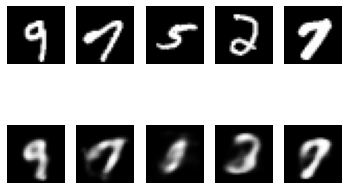

In [8]:
# BEGIN FILL IN CODE
ae_model.fit(X_train,X_train, epochs=n_epochs, batch_size=batch_size)

# END FILL IN CODE
test_images(ae_model, X_test)

## Convolutional model

Now, we are going to implement a convolutional architecture (with two dense layers in the middle) and compare the results. Implement the following architecture :

Encoder :
- 2D convolution, filter size $3\times3$, 8 filters, stride=(2,2), padding="SAME"
- LeakyReLU ($\alpha=0.2$)
- 2D convolution, filter size $3\times3$, 4 filters, stride=(2,2), padding="SAME"
- LeakyReLU ($\alpha=0.2$)
- Flatten tensor
- Dense layer, output size z_dim

Decoder :
- Dense layer, output size 196
- LeakyReLU ($\alpha=0.2$)
- Reshape $(7\times7\times 4)$
- 2D transposed convolution, filter size $3\times3$, 8 filters, stride=(2,2), padding="SAME"
- LeakyReLU ($\alpha=0.2$)
- 2D transposed convolution, filter size $3\times3$, 1 filter, stride=(2,2), padding="SAME"
- Sigmoid activation

The sizes of the tensors in the encoder and the decoder should be :
- $28 \times 28 \times 1$ -> $14 \times 14 \times 8$ -> $7 \times 7 \times 4$ -> z_dim
- z_dim -> $7 \times 7 \times 4$ -> $14 \times 14 \times 8$ -> $28 \times 28 \times 1$

Use the previous code as an example, and implement and train the architecture.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 7, 7, 4)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1970      
_________________________________________________________________
dense_13 (Dense)             (None, 196)              

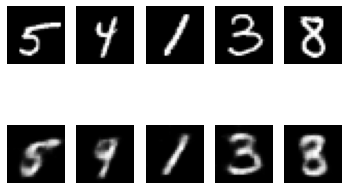

In [15]:
#BEGIN FILL IN CODE

ae_model2 = Sequential() 
ae_model2.add(Conv2D(filters=8, kernel_size=(3,3),strides=(2, 2), padding="same", input_shape=(28,28,1)))
ae_model2.add(LeakyReLU(alpha=0.2))
ae_model2.add(Conv2D(filters=4, kernel_size=(3,3),strides=(2, 2), padding="same"))
ae_model2.add(LeakyReLU(alpha=0.2))
ae_model2.add(Flatten())
ae_model2.add(Dense(z_dim))

ae_model2.add(Dense(196))
ae_model2.add(LeakyReLU(alpha=0.2))
ae_model2.add(Reshape((7,7,4)))
ae_model2.add(Conv2DTranspose(filters=8, kernel_size=(3,3),strides=(2, 2), padding="same"))
ae_model2.add(LeakyReLU(alpha=0.2))
ae_model2.add(Conv2DTranspose(filters=1, kernel_size=(3,3),strides=(2, 2), padding="same",activation="sigmoid"))


# display model
ae_model2.summary()

# compile model
ae_model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])

ae_model2.fit(X_train,X_train, epochs=n_epochs, batch_size=batch_size)
test_images(ae_model2, X_test)

#END FILL IN CODE

Are the performances better with this model ? Compare the number of parameters in the MLP and convolutional case

**Answer:** The results are better in a sense that they all look more like digits.  For example, in the MLP the digit 5 turned into something recognizable. But at the same time, the results of the CNN aren’t great, an 8 turned into something closer to a 3, and a 4 to a 9.


In the MLP we have a total of 16,474 parameters, while for the CNN 4,867. This is expected and shows how the number of parameters grows fast in the MLP given the size of the image (the MNIST images are relatively small).


## Denoising autoencoder

In this part, we take the previous architecture, but now we implement a __denoising__ autoencoder. For this, we simply add Gaussian noise to the input during training, and require the autoencoder to reconstruct the non-noisy ground truth. You can do add the noise using the following function :
- np.random.normal(loc=0.0, scale=1.0, size=curr_batch.shape)

First, we modify the ```test_images``` function to take into account a noisy input.

In [16]:

def test_images(ae_model, test_data, sigma):
  n_images = 5
  idx = np.random.randint(0, test_data.shape[0], n_images)
  test_imgs = test_data[idx,:,:,:]

  #get output images
  test_imgs = np.clip(test_imgs + sigma * np.random.normal(loc=0.0, scale=1.0, size=test_imgs.shape),0.,1.)
  output_imgs = ae_model.predict( test_imgs )
  
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[0,j].imshow(test_imgs[j, :,:,0], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, :,:,0], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

Now, use the previous codes to implement the denoising autoencoder. Use either the MLP architecture or the convolutional architecture.

__IMPORTANT NOTE__ For this part of the TP, you will have to use a custom training process (to add the noise to a batch). For this, you can use the following function :

- loss_value = ae_model.train_on_batch(X,Y)

This allows you to create a custom batch. X should be the noisy batch, and Y should be the non-noisy batch

In this case, to simplify things, __do not worry about carrying out the complete batch over the database__, simply iterate n_iters times, and select a random batch at each iteration. To select a random set (of size batch_size) of integers between 0 and X_train.shape, use :

- np.random.randint(0, X_train.shape[0], batch_size)

Use sigma = 25.0/255.0

[0.1308562159538269, 0.8092315196990967]
[0.13907359540462494, 0.7993064522743225]
[0.1386515349149704, 0.7909757494926453]
[0.12201698124408722, 0.8186782598495483]
[0.1438605785369873, 0.7935865521430969]
[0.1314256191253662, 0.7988680005073547]
[0.14212405681610107, 0.8008211255073547]
[0.132071852684021, 0.8048070669174194]
[0.12610872089862823, 0.8009207844734192]
[0.12701579928398132, 0.8103874325752258]


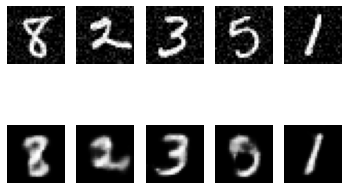

In [22]:

sigma = 25.0/255.0
n_iters = 1000
display_loss_step = 100

#BEGIN FILL IN CODE
for i in range(n_iters):
  curr_batch = X_train[np.random.randint(0, X_train.shape[0], batch_size),:,:,:]
  batch_noise = np.clip(curr_batch +  sigma * np.random.normal(loc=0.0, scale=1, size=curr_batch.shape),0.,1.)
  loss_value = ae_model2.train_on_batch(batch_noise,curr_batch)
  if (i%display_loss_step==0): print(loss_value )

test_images(ae_model2, X_test,sigma)
# END FILL IN CODE